# Data Science Essentials: GeoPandas
    Matthew Mella
    10/03/23

In [ ]:
# Run this cell if using Google Colab
! pip install geopandas
from google.colab import files

In [2]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
drop_codes = ['02', '15', '60', '66', '69', '72', '78']
county_gdf = gpd.read_file('county_data.gpkg')
reprojected_county_gdf = county_gdf.to_crs(5071)

/var/folders/6r/hg6ljwj9053_dvzxcp0nfzsm0000gn/T/ipykernel_21774/705532240.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


## Problem 1

Read in the file *airports.csv* as a pandas DataFrame.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates (Longitude and Latitude zipped together) to a *shapely.geometry.Polygon* object.

Then, create a new GeoDataFrame using a dictionary with key *'geometry'* and with a list of these three Polygons as the value.
Plot this GeoDataFrame, and then plot the outlined world map on top of it.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport

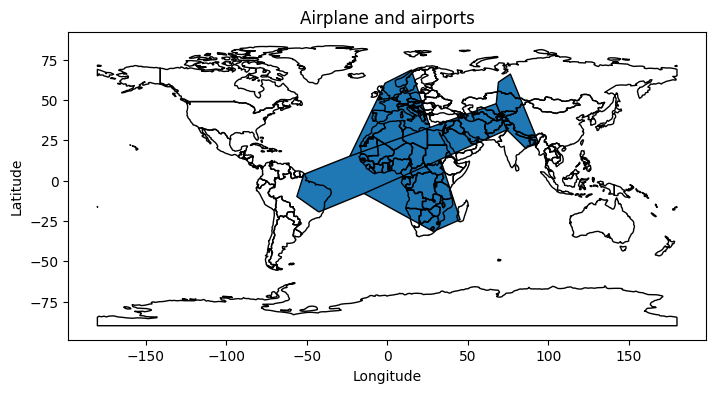

In [4]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

# read in the data
df = pd.read_csv("airports.csv")
# create polygons for each set
airport_polygons = [Polygon(list(zip(df.loc[df["Name"].isin(airport_set)].Longitude, df.loc[df["Name"].isin(airport_set)].Latitude))) for airport_set in [first_set, second_set, third_set]]
# create convext hulls
convex_hulls = [polygon.convex_hull for polygon in airport_polygons]
# create gdf
gdf = gpd.GeoDataFrame({'geometry': convex_hulls})
# plot data
fig, ax = plt.subplots(figsize=(10,4), ncols=1, nrows=1)
base = gdf.plot(ax=ax, edgecolor='black')
world.plot(ax=base, color='none', edgecolor='black')

ax.set_title('Airplane and airports')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## Problem 2

Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the boundaries of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines (*dissolve*) all counties within each state (*by='STATEFP'*).
Drop regions with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot the boundary of this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

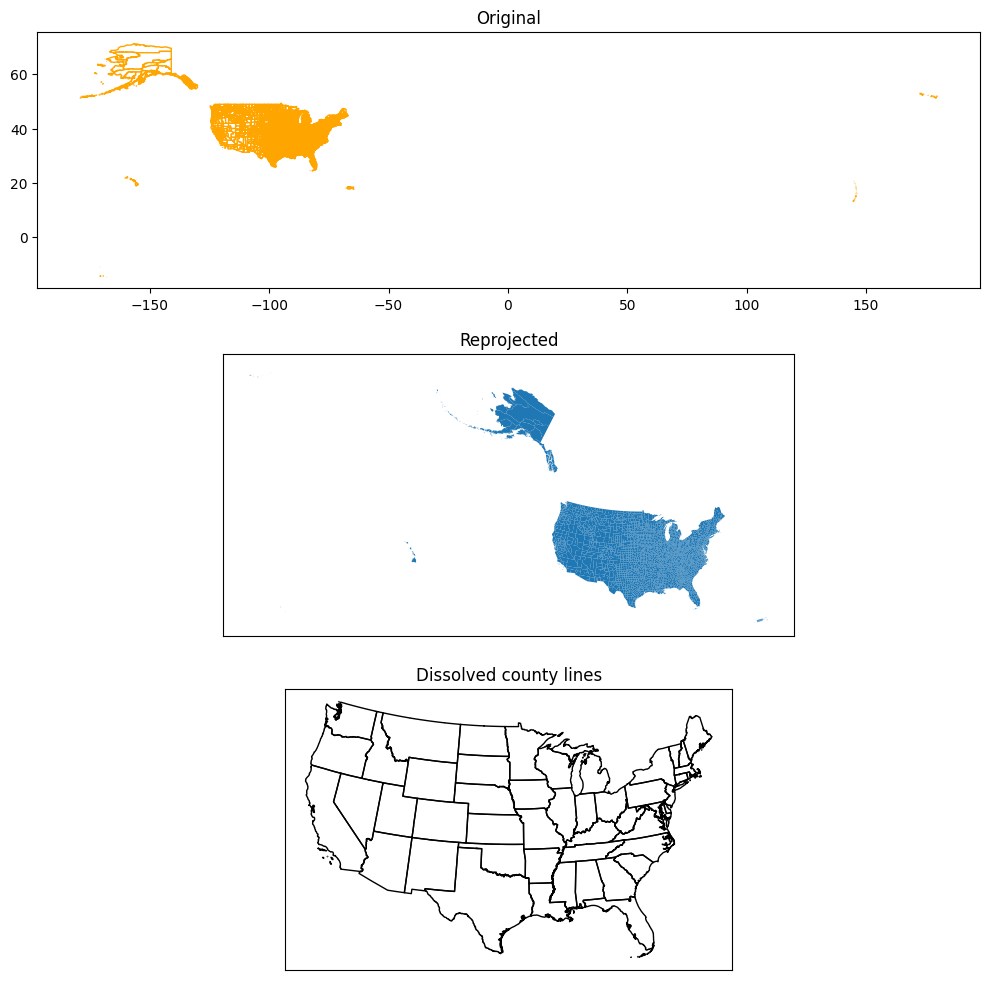

In [5]:
# create figure and plot country data
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=3)
county_gdf.plot(ax=ax[0], edgecolor='orange', color='white')
ax[0].set_title('Original')


# reproject the data and plot
reprojected_county_gdf.plot(ax=ax[1])
ax[1].set_title("Reprojected")
ax[1].set_xticks([])
ax[1].set_yticks([])

# select only from the 48 mainland states and dissolve county lines
country_gdf = county_gdf.loc[~county_gdf["STATEFP"].isin(drop_codes)].dissolve(by='STATEFP', aggfunc='sum')
country_gdf.to_crs(5071, inplace=True)
# plot data
country_gdf.plot(ax=ax[2], color='none', edgecolor='black')
ax[2].set_title("Dissolved county lines")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()
plt.show()


## Problem 3

Load in the file *nytimes.csv* as a Pandas DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.

Merge the county GeoDataFrame from *county_data.gpkg* with the *nytimes* DataFrame on the county *fips* codes (a FIPS code is a 5-digit unique identifier for geographic locations).
Note that the *fips* column of the *nytimes* DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three digits in the *COUNTYFP* column.
Thus, you will need to add these two columns together and then convert them into floats so they can be merged with the *fips* column in the *nytimes* DataFrame.

Drop the regions from the county GeoDataFrame with the same STATEFP codes as in Problem 2. Also, make sure to change the CRS of the county GeoDataFrame to EPSG:5071 *before* you merge the two DataFrames (this will make the code run much faster).

**Plot the cases from March 21, 2020, and then plot your state outline map from Problem 2 on top of that (with a CRS of EPSG:5071). 
Include a colorbar using the arguments *legend=True* and *cmap='PuBu_r'* in the *plot* function.
Finally, print out the name of the county with the most cases on March 21, 2020, along with its case count.**

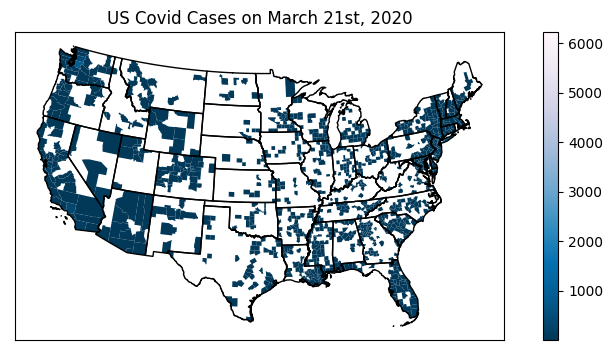

Calhoun


In [7]:
# read in covid data, select only from march 21
df = pd.read_csv("nytimes.csv")
df = df.loc[df['date'] == '2020-03-21']

# combine the statefp and countyfp into a float to merge on
reprojected_county_gdf['fips'] = (county_gdf['STATEFP'] + county_gdf['COUNTYFP']).astype(float)

# merge the 2 dfs and select 48 mainland states
gdf = reprojected_county_gdf.merge(df, on='fips')
gdf = gdf.loc[~gdf["STATEFP"].isin(drop_codes)]

# plot the data, showing a colormap
fig, ax = plt.subplots(figsize=(10,4), ncols=1, nrows=1)
ax.set_xticks([])
ax.set_yticks([])
base = gdf.plot(column='cases', ax=ax, legend=True, cmap='PuBu_r')
country_gdf.plot(ax=base, color="none", edgecolor="black")

plt.title("US Covid Cases on March 21st, 2020")
plt.show()

print(df.iloc[np.argmin(df['cases'])]['county'])

## Problem 4

As in Problem 3, plot your state outline map from Problem 2 on top of a map of Covid-19 cases from March 21, 2020 (each with a CRS of EPSG:5071).
This time, however, use a log scale.
Pick a good colormap (the counties with the most cases should generally be darkest) and be sure to display a colorbar.

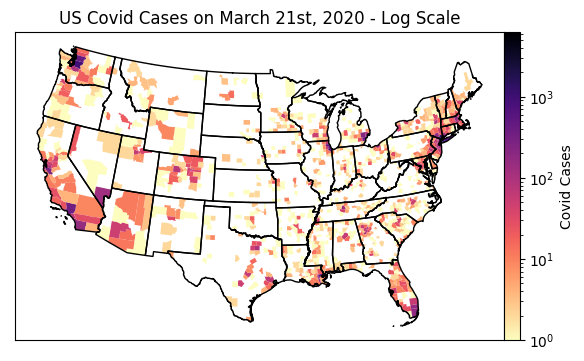

In [7]:
norm = LogNorm(vmin=min(gdf.cases), vmax=max(gdf.cases))
# plot the data, showing a norm colormap
fig, ax = plt.subplots(figsize=(10,4), ncols=1, nrows=1)
ax.set_xticks([])
ax.set_yticks([])
base = gdf.plot(column='cases', ax=ax, cmap='magma_r', norm=norm)
country_gdf.plot(ax=base, color="none", edgecolor="black")

fig.colorbar(ScalarMappable(norm=norm, cmap='magma_r'), ax=ax, orientation='vertical', pad=0, label='Covid Cases')

plt.title("US Covid Cases on March 21st, 2020 - Log Scale")
plt.show()

## Problem 5

In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020, through June 21, 2020.
You will use the same GeoDataFrame you used in Problems 3 and 4 (with a CRS of EPSG:5071).
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your *vmax* so that the scale remains uniform.
- Write your *update* function. This should plot the cases from a given day as well as the state boundaries.
- Set up your colorbar. Do this outside the *update* function to avoid adding a new colorbar each day.
- Create a *FuncAnimation* object. Check to make sure everything displays properly before you save it.
- Save the animation to a file, and embed it into the notebook.

In [15]:
# read in covid data, select only from march 21
df = pd.read_csv("nytimes.csv")

# combine the statefp and countyfp into a float to merge on
reprojected_county_gdf['fips'] = (county_gdf['STATEFP'] + county_gdf['COUNTYFP']).astype(float)

plt.ioff()

# figure and log
fig, ax = plt.subplots(1, figsize=(10,7))
norm = LogNorm(vmin=min(gdf.cases), vmax=max(gdf.cases))



def update(date):
    ax.clear()
    # select only the correct date
    date_df = df.loc[df['date'] == date]
    # Merge the dataframes and drop counties
    gdf = reprojected_county_gdf.merge(date_df, on='fips')
    gdf = gdf.loc[~gdf["STATEFP"].isin(drop_codes)]
    base = gdf.plot(column='cases', ax=ax, cmap='magma_r', norm=norm)
    country_gdf.plot(ax=base, color="none", edgecolor="black")
    
    # Reapply the title and remove axis lines here
    ax.set_title("Animated US Covid Cases, Jan 21 through Jun 21 - Log Scale")
    ax.set_xticks([])
    ax.set_yticks([])



# Set up the colorbar
fig.colorbar(ScalarMappable(norm=norm, cmap='magma_r'), ax=ax, orientation='vertical', pad=0, label='Covid Cases')

# Create animation object
ani = animation.FuncAnimation(fig, update, 
        frames=sorted(set(df['date'])),
        interval=1000*(1/30)) # Each frame is 1/30 of a second

plt.close(fig)

In [16]:
animation.writer = animation.writers['ffmpeg']

# Save / embed the animation

# Run this line and the following Markdown cell
ani.save('covid_spread.mp4')
# Don't forget to push the .mp4 file!

<video src="covid_spread.mp4" controls>